In [11]:
os.getcwd()
os.chdir('/Users/houlinyu/Documents/conductance_analysis/raw_data')
# !pip install -r requirements.txt

In [12]:
import xml.etree.ElementTree as ET
import pandas as pd
# Importing xlrd module 
import xlrd 
from datetime import datetime
# Initializing an excel serial date 


In [17]:
import os, fnmatch
filenames = fnmatch.filter(os.listdir('./'), '*.xml')

In [18]:
file_dir = []
for filename in filenames :
    fd = open(filename,'r')
    data = fd.read()
    ### convert to xmlfile into dataframe
    data = xml_to_dataframe(data)
    data['FileInfo'] = filename[:-4] 
    ### if you want to look at the each dfprint(df)
    file_dir.append(data)

len(file_dir)

4

In [20]:
## select needed colums, 'ExcelTime', 'PARe', 'gs','A' and convert excel time into time:
file_filter = []
for df in file_dir:
    df[['ExcelTime', 'PARi', 'gs', 'A']] = df[['ExcelTime', 'PARi', 'gs', 'A']].apply(pd.to_numeric, errors='coerce')
    df["Time"] = df['ExcelTime'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
    df2 = df.loc[:, ['Time', 'PARi', 'gs','A','FileInfo']]
    file_filter.append(df2)
        ### print(df2)
        ###convert time

In [21]:
### using the reference data to add the plant info
data_ref = []
ref = pd.read_excel('./measurement_reference.xlsx', index_col=0)
ref
for file in file_filter:
    file = file.merge(ref, on='FileInfo', how='left')
    file['PARi2'] = file['PARi'].apply(lambda x: 1000 if x >= 800 else 0)
    data_ref.append(file)

len(data_ref)

4

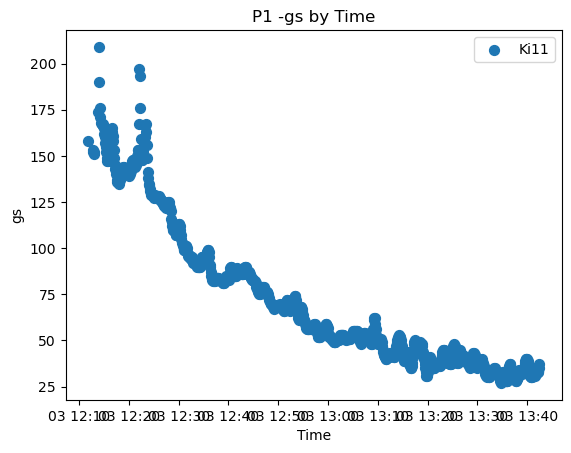

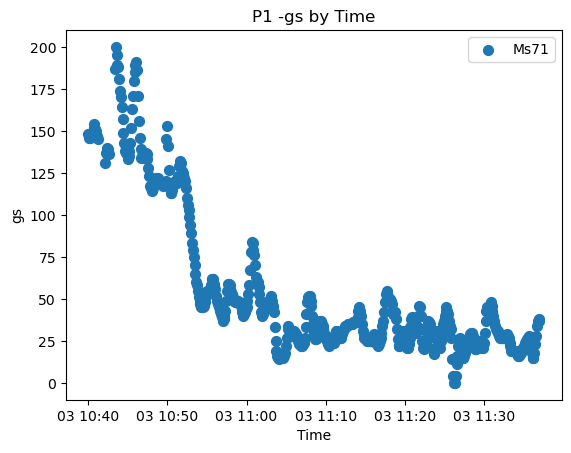

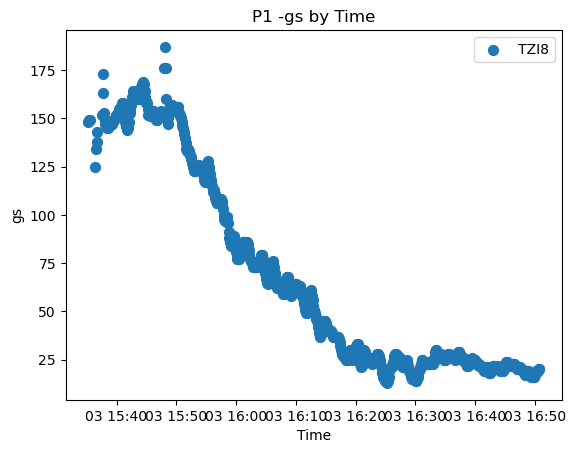

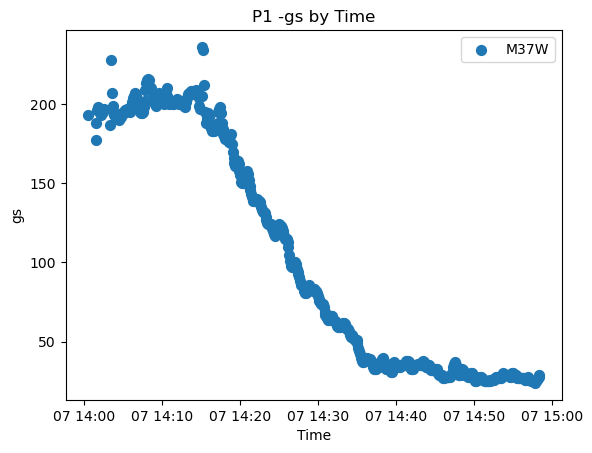

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
###Visulize each data to check the data good or not
for data1 in data_ref:
    plot_scatter(data1, x_column='Time', y_column='gs')


In [23]:
### Find the off start time
# Find the index of the first occurrence of 0 in the 'PARi2' column

reference_time = 20
def calculate_time_difference(df):
    df['Time_off'] = df['Time'] - df.loc[reference_time,'Time']
    return df

# Remove DataFrames with NaN values in the specified column
# Specify the column to check for NaN values
column_to_check = "Plant_Num"

data_ref = [df for df in data_ref if not df[column_to_check].isna().any()]

data_off = []
for data1 in data_ref:
    ###find the off start time
    off_start_col = (data1['PARi2'] == 0).idxmax()
    off_end_col = (data1['PARi2'] == 0).index.max()
    ## get the gs_zero col
    data1['gs_zero'] = data1.loc[off_start_col, 'gs']
    ## get the Rgs
    data1['Rgs'] = data1['gs']/data1['gs_zero']
    data = data1.iloc[(off_start_col-reference_time + 1):len(data1),:]
    data = pd.DataFrame(data)
    ## convert time to date and time
    data['Time'] = pd.to_datetime(data['Time'])
    data['date'] = data['Time'].dt.date
    data['Time'] = data['Time'].dt.time 
    data['Time'] = data['Time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
    data['Time_off'] = (data['Time'] - data.loc[off_start_col, 'Time'])/60
    ## Visulize the data
    #plot_scatter(data, x_column='Time_off', y_column='Rgs' )
    data_off.append(data)


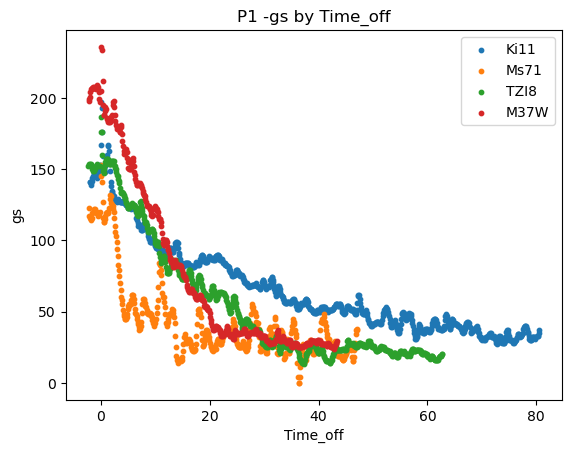

In [25]:
combined_df = pd.concat(data_off, ignore_index=True)
combined_df 
plot_scatter(combined_df, x_column='Time_off', y_column='gs', size= 10)      

In [26]:
##Function to convert xml2dataframe

def xml_to_dataframe(xml_data):
    # Parse the XML data
    root = ET.fromstring(xml_data)

    # Initialize an empty list to store data
    data_list = []

    # Iterate through each 'Ciras3DataRecord' element in the XML
    for record in root.findall('.//Ciras3DataRecord'):
        record_data = {}

        # Iterate through each attribute of the 'Ciras3DataRecord'
        for key, value in record.attrib.items():
            record_data[key] = value

        # Append the record data to the list
        data_list.append(record_data)

    # Create a DataFrame from the list
    df = pd.DataFrame(data_list)

    return df

In [27]:
### visualize the data
import matplotlib.pyplot as plt
import pandas as pd

def plot_scatter(data_frame, x_column='Time', y_column='A', color_by='Genotype', size=50):
    """
    Plot a scatter plot for specified columns in a DataFrame.

    Parameters:
    - data_frame: The DataFrame containing 'Time', 'A', 'gs', 'Genotype', 'Plant_Num'.
    - x_column: The column to be plotted on the x-axis (default is 'Time').
    - y_column: The column to be plotted on the y-axis (default is 'A').
    - color_by: The column to use for coloring the points (default is 'Genotype').
    - size: The size of the points in the scatter plot (default is 50).

    Returns:
    - None
    """
    # Input validation
    required_columns = ['Time', 'A', 'gs', 'Genotype', 'Plant_Num']
    for col in required_columns:
        if col not in data_frame.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Plotting with matplotlib
    unique_colors = data_frame[color_by].unique()

    for color in unique_colors:
        subset = data_frame[data_frame[color_by] == color]
        plt.scatter(subset[x_column], subset[y_column], s=size, label=color)

    # Adding labels and legend
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.legend()
    
    # Set the dynamic title
    # Set the dynamic title with Plant_Num if provided
    Plant_Num = data_frame.loc[1,'Plant_Num']

    title = f'{Plant_Num} -{y_column} by {x_column}'
    plt.title(title)


    # Show the figure
    plt.show()

# Example usage:
# plot_scatter(my_dataframe, x_column='Time', y_column='gs', color_by='Genotype', size=60)
